# Amazon Reviews - Sampling, Exploration and Experimentation 

The first stage to any data science project working with extremely large datasets is to first take a look at a sample of the data and perform some basic exploration and modelling processes.

In the following notebook, we're going to be taking our pre-processed dataset from our AWS GLUE process (step 0), and then apply sampling techniques in order to generate a statistically sound sample of the 145million reviews data. Based on this sample dataset, we're going to start to explore the characteristics of the data (e.g. descriptive statistics), and then proceed with basic modelling the data to understand the predictive nature of the features for different predictive tasks.

### Imports

The following imports are required in order to run different statistical tests and modelling techniques.

In [ ]:
# NOTE: Uncomment the folllowing lines if you 
# !conda install -y -c conda-forge fastparquet scikit-learn arrow-cpp parquet-cpp pyarrow numpy
# !pip install --upgrade mxnet gluonnlp swifter dask cufflinks


In [1]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import pandas as pd
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
import nltk
from fastparquet import write
from fastparquet import ParquetFile
import s3fs
import pyarrow.parquet as pq
import pickle
import glob
import ast 
import csv
import itertools
import dask.dataframe as dd
from dask.multiprocessing import get
import multiprocessing


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics


### Configs and Global Vars

In [2]:
configs = {
    'aws_region' :  'us-east-1',
    'bucket_name': 'demos-amazon-reviews',
    'prefix' : 'preprocessed_reviews_csvs', #only use this if you want to have your files in a folder 
    'index_key' : 'review_date_str',
    'file_extension' :'.csv',
    'wordvecdata': 'wordvec-data'
}

global_vars = {}

### Environment Setup

Setting up the environment involves ensuring all the corret session and IAM roles are configured. We also need to ensure the correct region and bucket is made available.

In [3]:
def setup_env(configs, global_vars):
    
    sess = sagemaker.Session()
    
    role = get_execution_role()

    AWS_REGION = configs['aws_region']
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(configs['bucket_name'])

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
        
    global_vars['role'] = role
    global_vars['sess'] = sess
    global_vars['s3'] = s3
    global_vars['s3_bucket'] = s3_bucket
    
    return global_vars

global_vars = setup_env(configs, global_vars)

Bucket already exists


### Create Data Manifest

At this step, we need to create an index of all the files we're going to be using for this experiment and model building. Now, we don't want to download all of the data at once, or we're going to cause a lot of I/O activity for your Notebook Instance. 

What we're going to do is first create a path index to where the files live on S3. From there, we can do some sampling to get to see what the data looks like, do some basic sampling stats on the data, to get a better handle on how we should build a model, and then move to using all the data to build a robust model!

In [ ]:
def create_dataset_manifest(configs, global_vars):
    
    interval_printer_idx = 100
    idx = 0
    1
    conn = global_vars['s3_bucket']
    file_format = configs['file_extension']
    index_key = configs['index_key']+'='
    s3_prefix = configs['prefix']+'/'
    manifest = []    
    for file in conn.objects.filter(Prefix=s3_prefix):
        path = file.key
#         print(file)
        if (file_format in path):
#             print(path)
            relative_path = path.replace(configs['prefix'],'')
            date = relative_path.split('/')[1].replace(index_key,'')

            man = {'idx':idx, 'path':relative_path, 'path_with_prefix':path, 'date':date}
            manifest.append(man)  
            idx += 1
            if (idx % interval_printer_idx) == 0:
                print('Processed {} files'.format(idx))
    print('Training Dataset Size {}'.format(len(manifest)))
    return manifest
            
manifest = create_dataset_manifest(configs, global_vars)   
    

In [ ]:
def count_lines(configs, global_vars, entry):
        
    s3 = boto3.client('s3')

    resp = s3.select_object_content(
        Bucket=configs['bucket_name'],
        Key=entry['path_with_prefix'],
        ExpressionType='SQL',
        Expression="SELECT count(*) FROM s3object s",
        InputSerialization = {'CSV':
                              {"FileHeaderInfo": "Use", 
                               "AllowQuotedRecordDelimiter": True,
                               "QuoteEscapeCharacter":"\\",
                              }, 
                              'CompressionType': 'NONE'},
        OutputSerialization = {'CSV':{}},
    )
    
    for event in resp['Payload']:
        if 'Records' in event:
            records = event['Records']['Payload'].decode('utf-8')
#             print('Rows:',records)
            return(int(records))
    
count_lines(configs, global_vars, manifest[240])

### Explore Manifest Stats

Given that we know what the index of our manifest is partitioned by, let's do some simple stats to learn more about our manifest so we can make some informed decisions for our sampling and modelling

In [ ]:
def generate_manifest_statistics(configs, global_vars, manifest):
    
    date_cnt = {}
    stats = {}

    for entry in manifest:
        
        date = entry['date']
        cnt = count_lines(configs, global_vars, entry)
        date_cnt[date] = cnt
        print(date,cnt)

    tmp = []
    for date, cnt in date_cnt.items():
        itm = {'date':date, 'files':cnt}
        tmp.append(itm)
    df_stats = pd.DataFrame(tmp)
    df_stats.plot.bar(x='date', y='files', figsize=(40,10))  
    df_stats.plot.kde()
    print('Total folders {}'.format(df_stats.shape[0]))
    print('Total Files {}'.format(df_stats.sum()['files']))
    print('Date with most files {}. Files: {}'.format(df_stats.max()['date'], df_stats.max()['files']))
    print('Date with least files {}. Files: {}'.format(df_stats.min()['date'], df_stats.min()['files']))
    print('File Kurtosis/Skew {}/{}'.format(df_stats.kurtosis()['files'], df_stats.skew()['files']))

    notes = '''
        once we examine the distribution, we can determine how we are going to sample our manifest to get a better 
        understanding of our reviews. Remember the plot only represents the number of files in each folder. but
        there is a linear relationship between the number of files, and the number of reviews per bin'''
    
    print(notes)
    
    return df_stats
    
manifest_df_stats = generate_manifest_statistics(configs,global_vars, manifest)

### Generate Sample Dataset

Now we're going to generate a sample of our dataset to ensure that we get some views of how the data looks and feels across the years.

In [ ]:
def generate_sample_dataset(configs, manifest, manifest_df_stats, sample_size_pct = 0.01, strategy = 'binned_normal'):
    
    dfs_sampled = []
    index_key = configs['index_key']+'='

    notes = '''
        Based on the manifest inspection, we can now use a suitable sampling strategy in order to generate a smaller 
        manifest to work on locally.'''
    
    strategies = ['statified', 'random', 'clustered', 'systematic', 'binned_normal']
    if strategy in strategies:
        print('Using {} Strategy'.format(strategy))
    else:
        print('Please use one of these strategies {}'.format(strategies))
    
    if strategy is 'binned_normal':
        sample_meta = {}
        #we take a pct of each of the rows, and then use random to select within each bin
        #workout the overall pct we need to take
#         sample_pct = float(manifest_df_stats.shape[0] * sample_size)
        for idx,row in manifest_df_stats.iterrows():
            to_sample = int(row['files'] * sample_size_pct)
            if to_sample < 1:
                to_sample = 1
            date = row['date']    
            tmp = {'rows':row['files'], 'samples': to_sample, 'sampled_added':0}
            sample_meta[date] = tmp
            
#         print(sample_meta)
        #now we generate a new manifest
        
        sampled_manifest = []
        for entry in manifest:

            date = entry['path'].split('/')[1].replace(index_key,'')
            #get the meta data 
            meta = sample_meta[date]
            to_skip = meta['samples']
            if to_skip == 1:
                to_skip = 1
            full_path = 's3://'+configs['bucket_name']+'/'+entry['path_with_prefix']
            df = pd.read_csv(full_path, nrows=int(to_skip), header=0, error_bad_lines=False, escapechar="\\")
            print(date, df.shape)
            dfs_sampled.append(df)
        
    elif strategy in strategies:
        print('Other Stratigies will be supported Soon!')
    
    sampled_data = pd.concat(dfs_sampled)

    print('New Dataset Length {}'.format(sampled_data.shape[0]))
    
    return sampled_data
    
sampled_data = generate_sample_dataset(configs, manifest, manifest_df_stats)

In [4]:
def save_load_sample_df_to_file(df, path = 'data', file_name_prefix='', operation='save', chunkSize = 100000):
    
    
    loaded = []
    #first split the df as it's too big probably
    listOfDf = list()
    if operation == 'save':

        numberChunks = len(df) // chunkSize + 1
        for i in range(numberChunks):
            listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
            
        for i in range(0, len(listOfDf)):
            chunk_df = listOfDf[i]
            df_tmp_name_prefix = '{}/{}_part_{}.pkl'.format(path, file_name_prefix, str(i))
            chunk_df.to_pickle(df_tmp_name_prefix) 
                       
        return df
                       
    if operation == 'load':
        root_name = '{}/{}_*.pkl'.format(path, file_name_prefix)
        files = glob.glob(root_name)
        for fl in files:       
            print(fl)
            df = pd.read_pickle(fl)
            loaded.append(df)
                       
        return pd.concat(loaded)
    
sampled_data = save_load_sample_df_to_file(None, path='data', file_name_prefix = 'sample_df', operation='load')   

data/sample_df_part_7.pkl
data/sample_df_part_5.pkl
data/sample_df_part_14.pkl
data/sample_df_part_6.pkl
data/sample_df_part_12.pkl
data/sample_df_part_4.pkl
data/sample_df_part_8.pkl
data/sample_df_part_1.pkl
data/sample_df_part_2.pkl
data/sample_df_part_9.pkl
data/sample_df_part_0.pkl
data/sample_df_part_3.pkl
data/sample_df_part_10.pkl
data/sample_df_part_11.pkl
data/sample_df_part_13.pkl


In [5]:
def ready_sample_data(df):
    
    print('Dataset Rows {}, Columns {}'.format(df.shape[0], df.shape[1]))
    df['review_date']= pd.to_datetime(df['review_date']) 
    #convert date to string with format yyyy-mm
    df['review_date_str'] = df['review_date'].dt.strftime('%Y-%m')
    
    #here we need to do some basic filtering of rows, we don't want to start to model for 
    df_len = df.shape[0]
    pct_min = 0.01
    min_product_category_row_count = df_len * pct_min #should be around 1% of the dataset, Imbalanced data will skew our modelling
    
    df = df.groupby('product_category').filter(lambda x : len(x)>min_product_category_row_count)

    print('After Processing Data: Dataset Rows {}, Columns {}'.format(df.shape[0], df.shape[1]))

    return df

sampled_data = ready_sample_data(sampled_data)

Dataset Rows 1487293, Columns 18
After Processing Data: Dataset Rows 1437684, Columns 19


### Post Data Load Dataset Review

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'star_rating', 'helpful_votes',
       'total_votes', 'vine', 'verified_purchase', 'review_headline',
       'review_body', 'review_date', 'year', 'product_category', 'body_len',
       'review_body_processed', 'review_date_str'],
      dtype='object')
(1437684, 19)
        customer_id  product_parent   star_rating  helpful_votes
count  1.437684e+06    1.437684e+06  1.437684e+06   1.437684e+06
mean   2.854710e+07    4.998316e+08  4.202209e+00   1.805442e+00
std    1.558695e+07    2.883550e+08  1.252194e+00   1.445953e+01
min    1.001400e+04    5.760000e+02  1.000000e+00   0.000000e+00
25%    1.473634e+07    2.506303e+08  4.000000e+00   0.000000e+00
50%    2.772966e+07    4.998551e+08  5.000000e+00   0.000000e+00
75%    4.330486e+07    7.496030e+08  5.000000e+00   1.000000e+00
max    5.309659e+07    9.999999e+08  5.000000e+00   1.049800e+04


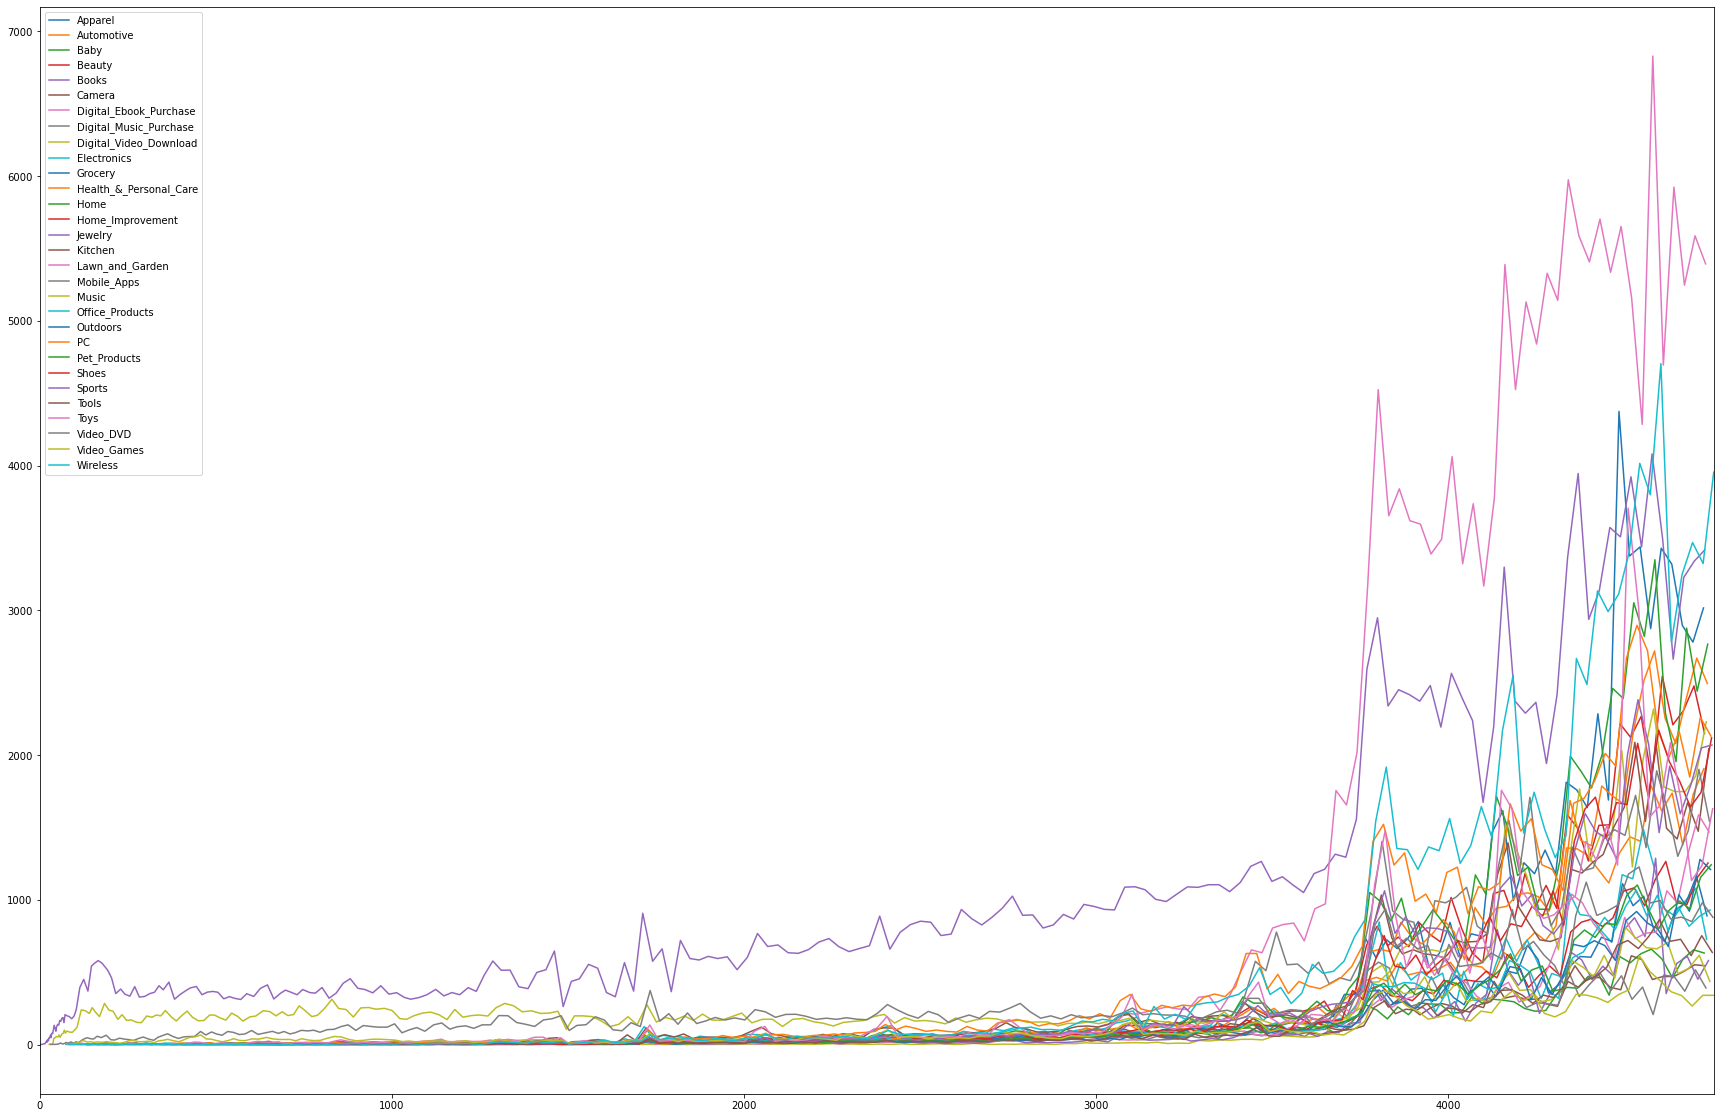

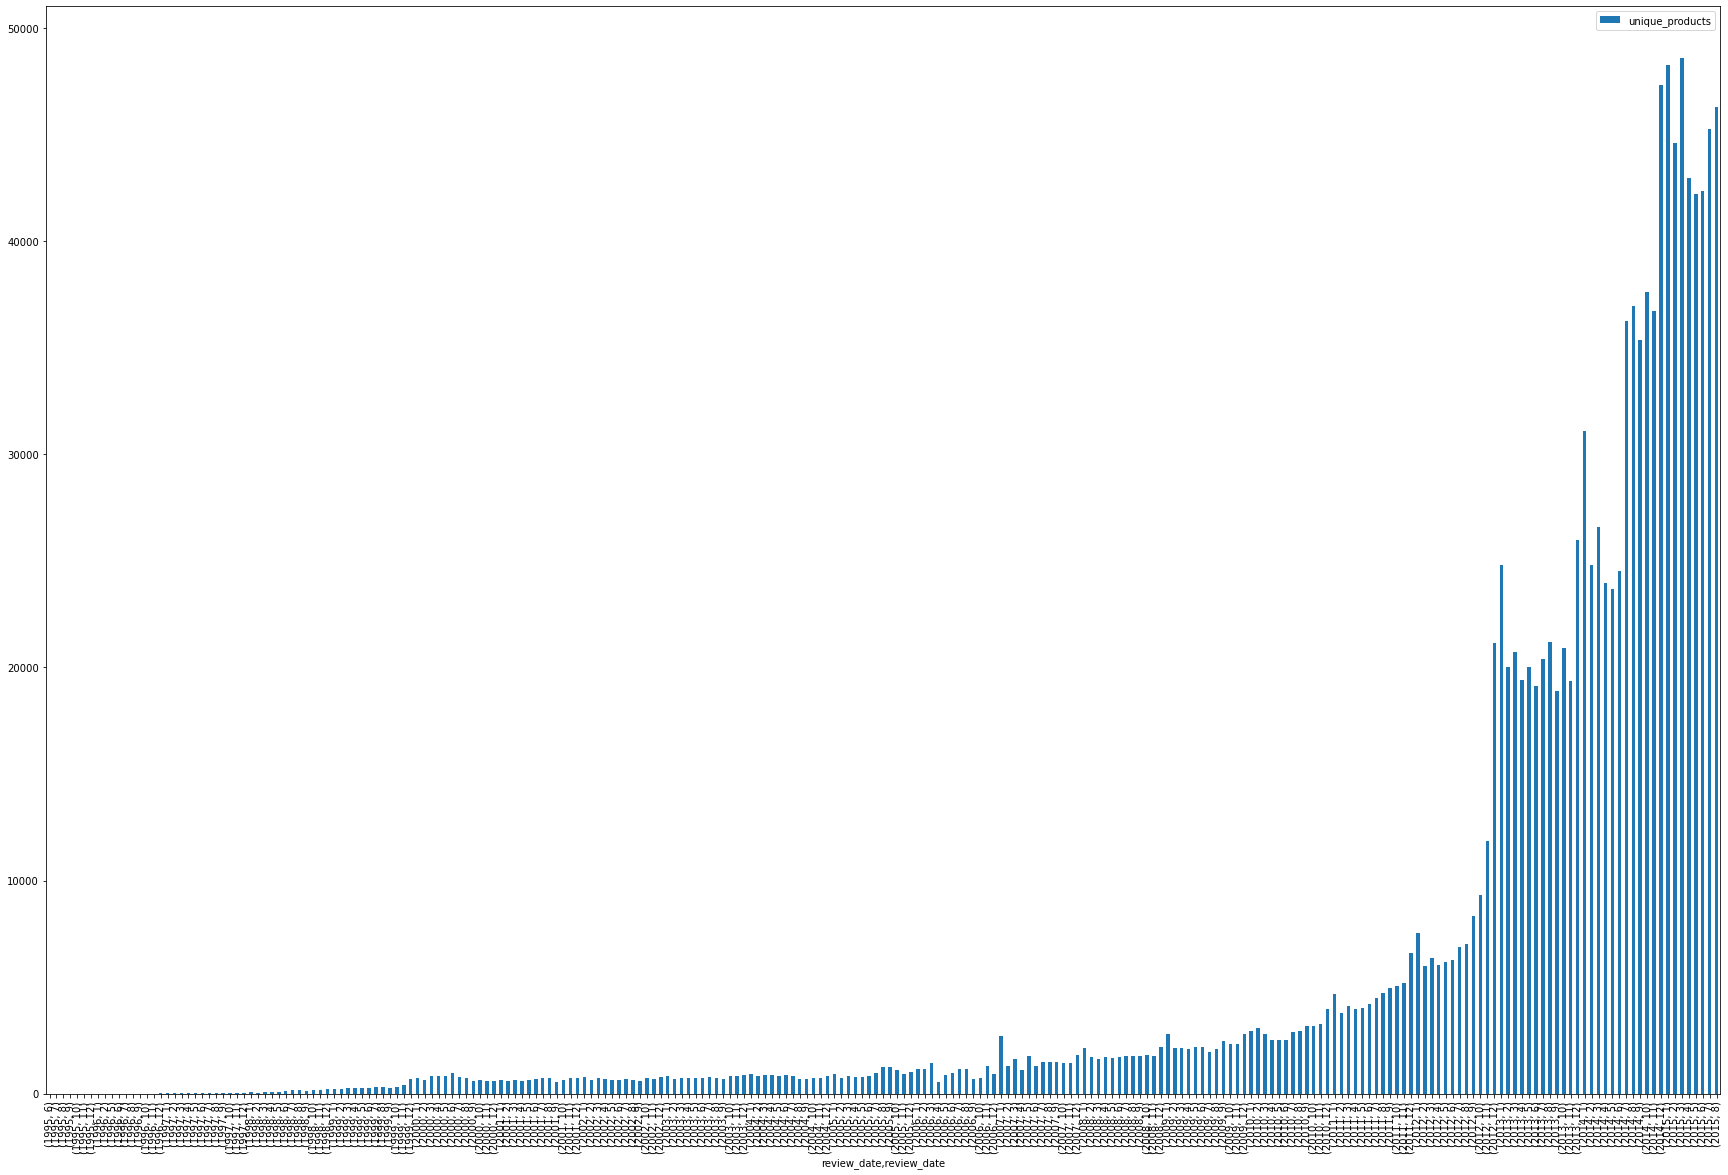

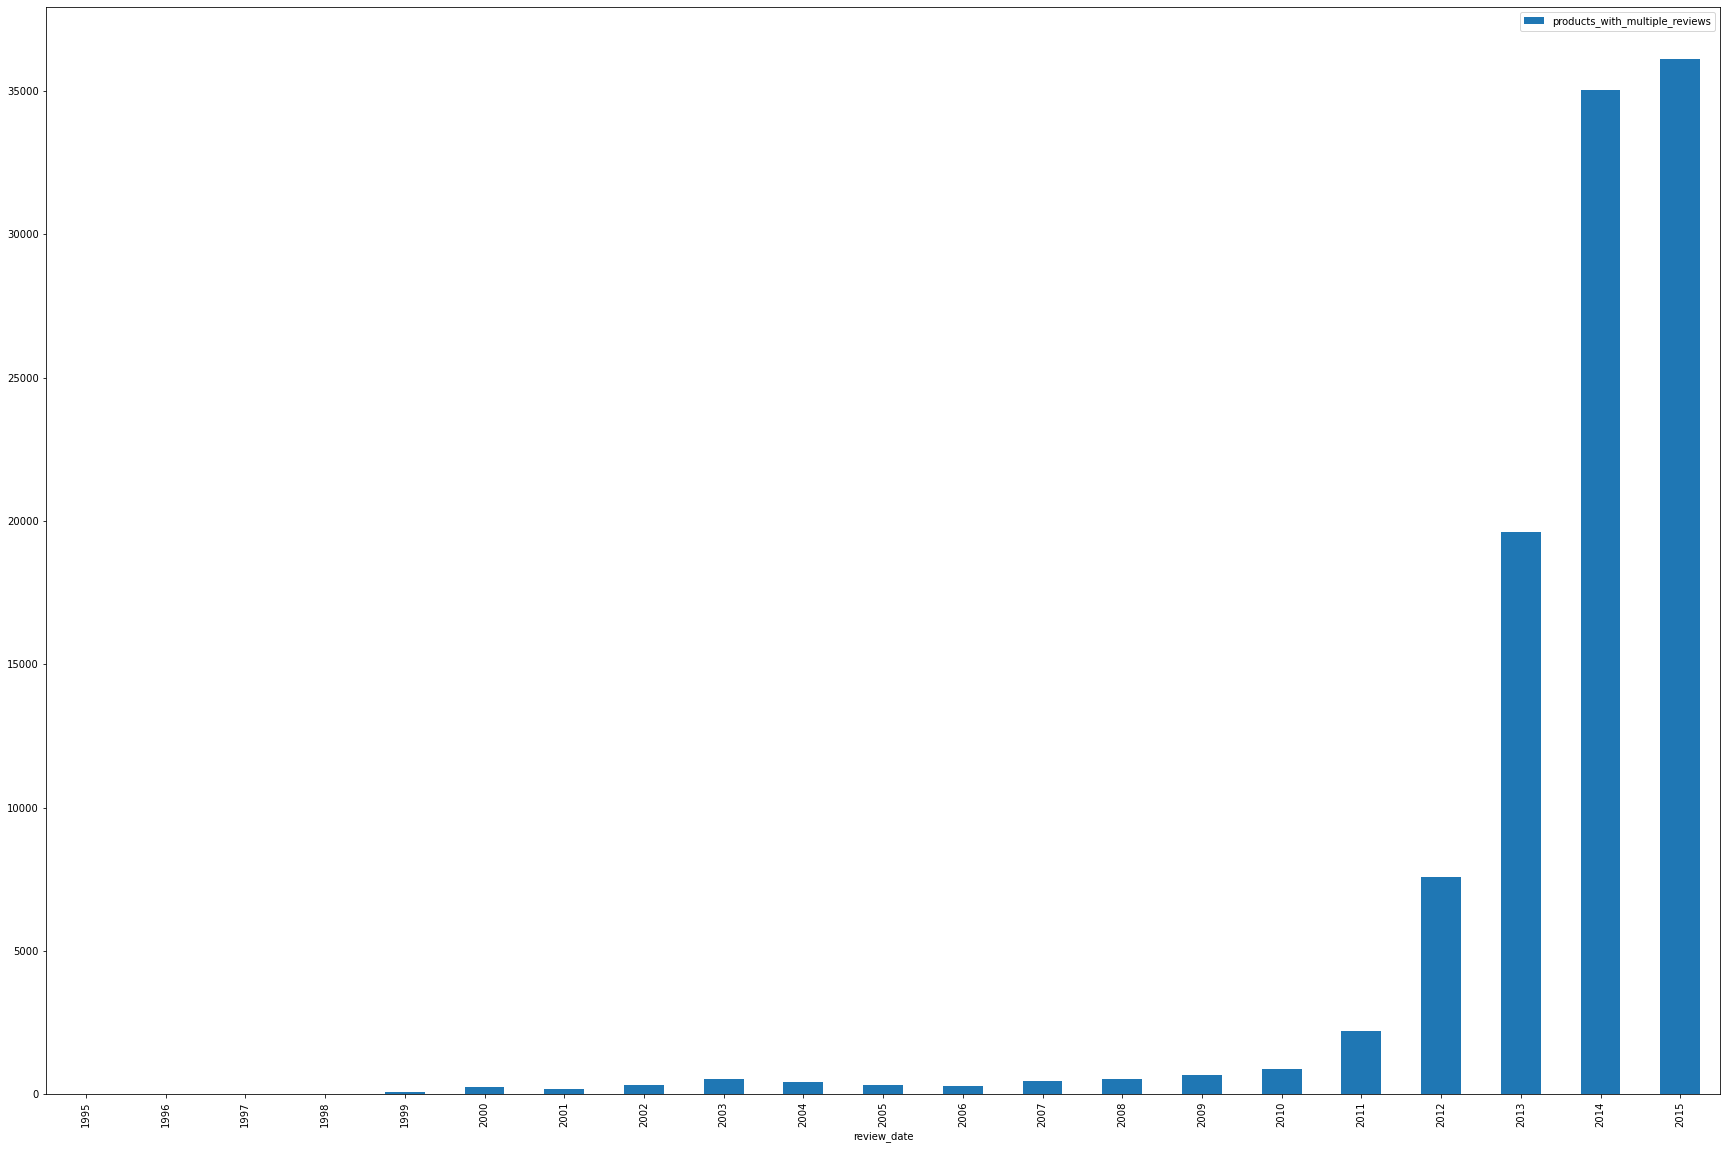

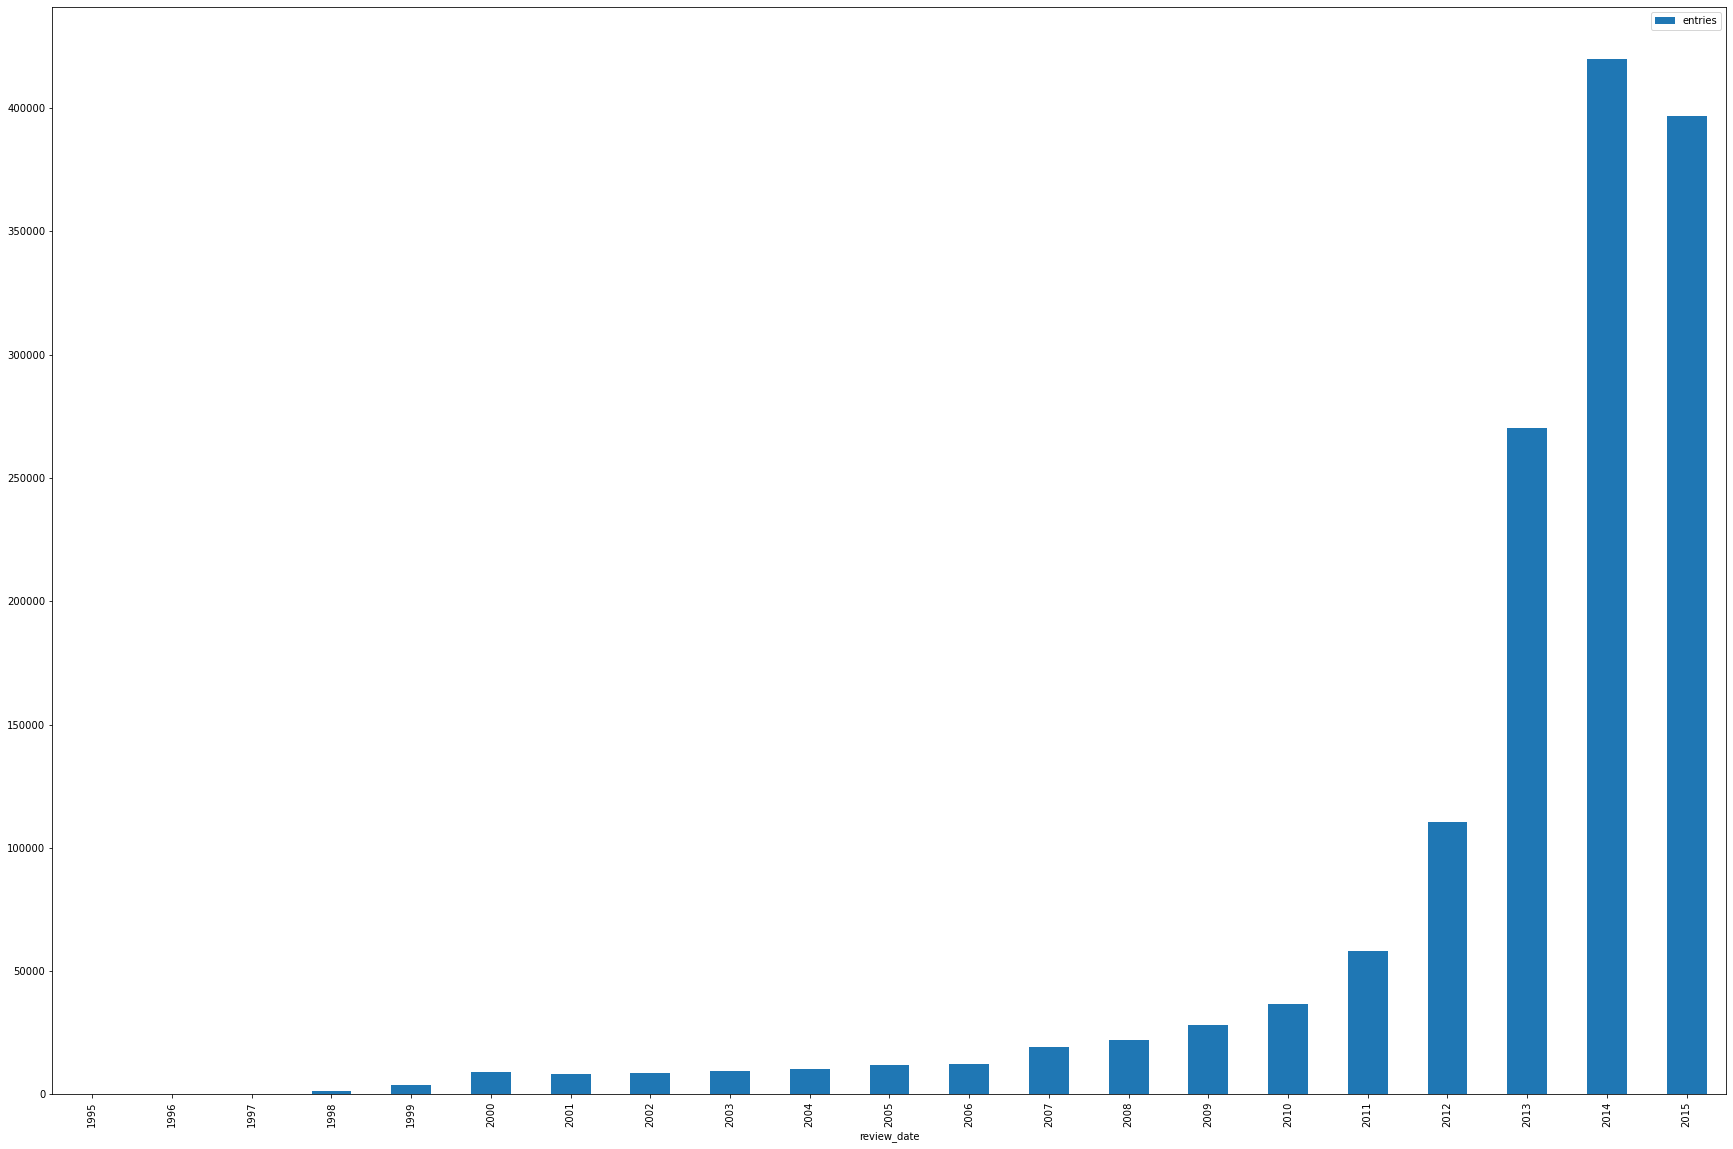

In [13]:
def analyse_sample_dataset(df):
   

    print(df.columns)
    print(df.shape)
    print(df.describe())

#     print(df.groupby(['review_date_str','product_category']).count())
    tmps = []
    for name,group in df.groupby(['review_date_str','product_category']):
        unique_products = len(group['product_id'].unique().tolist())
        products_with_multiple_reviews = group.shape[0]- unique_products
        tmp = {'review_date': name[0],
               'product_category': name[1], 
               'entries':group.shape[0], 
               'unique_products':unique_products,
              'products_with_multiple_reviews':products_with_multiple_reviews }
#         print(name, group.shape[0], unique_products)

        tmps.append(tmp)
    
    df_counts_cat_years = pd.DataFrame(tmps)
    df_counts_cat_years['review_date']= pd.to_datetime(df_counts_cat_years['review_date']) 
    df_counts_cat_years.groupby('product_category')['entries'].plot(legend=True, figsize=(30,20)) 
    plt.show()    
    
    df_counts_cat_years.groupby([df_counts_cat_years['review_date'].dt.year, df_counts_cat_years['review_date'].dt.month]).sum()['unique_products'].plot(kind='bar', legend=True, figsize=(30,20)) 
    plt.show()
   
    df_counts_cat_years.groupby(df_counts_cat_years['review_date'].dt.year).sum()['products_with_multiple_reviews'].plot(kind='bar',legend=True, figsize=(30,20))
    plt.show()

    df_counts_cat_years.groupby(df_counts_cat_years['review_date'].dt.year)['entries'].sum().plot(kind='bar',legend=True, figsize=(30,20))
    plt.show()
    
analyse_sample_dataset(sampled_data)

## Model /Analysis Experimentation (Local Mode)

The purpose of this section is to perform some experimentations with different modelling techniques.

We're first going to perform some local experiments on the 1% sample of data to see which methods provide valuable insights for both customers (e.g. Amazon Customer), and operations (e.g. Amazon). 

We want to look at different type of insights, from understanding how customer reviews have changed over times, and whether there is predictability in the type of review, and the category of product it is related to. 

Let's start of by first gettign our data into a shape which we can use for analysis and modelling purposes

### Prep Data for Modelling Purposes

We're going to develop some dataframes which represent our Xs and Ys (features and labels).

Let's create some feature/label datasets which are shaped around the following labels:

- year_product-category
- product-category_star_rating

The features for this model will be only using the text of the reviews





In [ ]:
def transform_data_for_modelling_use(df):
    
    #first let's get all our data in correct buckets of features and labels
    tmps = list()
    
    #first let's do the year_product-category grouping
    for name,group in df.groupby([df['review_date'].dt.year,'product_category']):
        label = '{}_{}'.format(name[0],name[1])
#         print(label)
        tokens = list()
        reviews = group['review_body_processed']
        for review in reviews:
#             print (type(review)) 
            res = str(review).strip('][').split(', ') 
            tokens.append(res)
#         print(len(tokens))
        tmp = {'tokens':tokens, 'label':label }
#         print(tmp)
        tmps.append(tmp)
    
    df_year_product_category = pd.DataFrame(tmps)

    tmps = list()
    #let's do the product-category-rating grouping
    for name,group in df.groupby(['product_category','star_rating']):
        label = '{}_stars_{}'.format(name[0],name[1])
        print(label)
        tokens = list()
        reviews = group['review_body_processed']
        for review in reviews:
            res = str(review).strip('][').split(', ') 
            tokens.append(res)
        tmp = {'tokens':tokens, 'label':label }
        tmps.append(tmp)
    
    df_product_category_rating = pd.DataFrame(tmps)

    
    return df_year_product_category, df_product_category_rating

df_year_product_category, df_product_category_rating = transform_data_for_modelling_use(sampled_data)        

### Save the features for use later

As these dataframes can take a while to generate, it's useful to save them if the notebook is shutdown, or the kernal dies. These things happen:)

In [ ]:
save_load_sample_df_to_file(df_year_product_category, 
                            path='data', 
                            file_name_prefix = 'features_df_year_product_category', 
                            operation='save', chunkSize=10)   

save_load_sample_df_to_file(df_product_category_rating, 
                            path='data', 
                            file_name_prefix = 'features_df_product_category_star', 
                            operation='save', chunkSize=10)   

## TF-IDF - Temporal Analysis of Product Categories


In [ ]:
#util code

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [ ]:
def generate_label_category(row, grouping_type):
    
    if grouping_type == 'year':
        label = row['label']
        category = "_".join(label.split('_')[1:])
        sub_cat = label.split('_')[0]
        
        
    if grouping_type == 'star':
        label = row['label']
        category = label.split('stars')[0]
        sub_cat = label.split('stars')[1]
        
    return category, sub_cat
        
        
    

def prepare_data_for_tfidf(df, grouping_type):
     
    data_grouped = dict()
    for idx,row in df.iterrows():
#         label = row['label']
#         category = "_".join(label.split('_')[1:])
#         year = label.split('_')[0]
        category, sub_cat = generate_label_category(row, grouping_type)
        if category in data_grouped:
            docs = data_grouped[category]
        else:
            docs = list()

        tokens = row['tokens']
        docs_tmp = [" ".join(x) for x in tokens]
        docs = docs + docs_tmp
        data_grouped[category] = docs
    
    tfidf_handlers = dict()
    for k,v in data_grouped.items():
        print(k, len(v))
        cv = CountVectorizer(max_features=10000)
        word_count_vector=cv.fit_transform(v)
        feature_names=cv.get_feature_names()
        tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
        tfidf_transformer.fit(word_count_vector)
        tfidf_handlers[k] = {'cv': cv, 'feature_names': feature_names, 'tfidf_transformer':tfidf_transformer}

    tfidf_scores = {} #keep track of tf-idf scores for category by year
    for idx,row in df.iterrows():
        
        category, sub_cat = generate_label_category(row, grouping_type)

        if category in tfidf_scores:
            sub_scores = tfidf_scores[category]
        else:
            sub_scores = dict()

        tfidf_transformer=tfidf_handlers[category]['tfidf_transformer']
        feature_names=tfidf_handlers[category]['feature_names']
        cv=tfidf_handlers[category]['cv']
        tokens = row['tokens']
        doc = [" ".join(x) for x in tokens]

        tf_idf_vector=tfidf_transformer.transform(cv.transform(doc))
        sorted_items=sort_coo(tf_idf_vector.tocoo())
        keywords=extract_topn_from_vector(feature_names,sorted_items,100)
        
        sub_scores[sub_cat] = keywords
        tfidf_scores[category] = sub_scores

    return tfidf_scores

tfidf_scores = prepare_data_for_tfidf(df_year_product_category, grouping_type='year')

### Temporal Overlap in TF-IDF Terms

In [ ]:
def calc_temporal_overlap_tfidf(dic_of_scores):
    
    tfidf_overlaps = []
    for k,v in dic_of_scores.items():
            ordered = OrderedDict(v)
            keys = list(ordered.keys())
            for i in range(0, len(keys)):
                if i < len(keys)-1:
                    year_n = keys[i]
                    year_n1 = keys[i+1]
                    bag = '{}_{}'.format(year_n,year_n1)
                    total_terms = set(ordered[year_n].keys()).union(set(ordered[year_n1].keys()))
                    overlap = set(ordered[year_n].keys()).intersection(set(ordered[year_n1].keys()))
                    pct_overlap = len(overlap) / len(total_terms)*100
                    tmp = {'category':k, 'year_from_to':year_n1, 'overlap_pct':pct_overlap}
                    tfidf_overlaps.append(tmp)
                
    df = pd.DataFrame(tfidf_overlaps)
    df['year_from_to']= pd.to_datetime(df['year_from_to']) 

    return df
                    
            
df_overlaps_tfidf = calc_temporal_overlap_tfidf(tfidf_scores)

In [ ]:
def plot_temporal_overlap(df):

    plt.figure(figsize=(20,15)) 

    for name, group in df.groupby('category'):
        x = group['year_from_to'].dt.year
        y = group['overlap_pct']
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        if z[0] < 0.5:
    #     plt.plot(x,y, label=name)
            plt.plot(x,p(x), label=name)

    plt.legend()
    plt.show()

plot_temporal_overlap(df_overlaps_tfidf)

**Notes**: At this point we can reflect on the results of the TF-IDF analysis to determine whether the terms which are being identified are useful, and also whether the transfer of terms across the years provides any value with respects to the overall consistency of language used within the reviews. One way of thinking about the results is that the language overlap could be considered as a metric of homogenity within the review samples. The current approach does not normalize against new products being introduced throughout the years, so it may be that this analysis is contaminated due to this factor.

### Perform Same exploration with Product Cateogry - Star Rating Analysis

In [ ]:
def calc_star_rating_overlap_tfidf(dic_of_scores):
    
    tfidf_overlaps = []
    for k,v in dic_of_scores.items():
            ordered = OrderedDict(v)
            keys = list(ordered.keys())
            for i in range(0, len(keys)):
                if i < len(keys)-1:
                    star_n = keys[i]
                    star_n1 = keys[i+1]
                    bag = '{}_{}'.format(star_n,star_n1)
                    total_terms = set(ordered[star_n].keys()).union(set(ordered[star_n1].keys()))
                    overlap = set(ordered[star_n].keys()).intersection(set(ordered[star_n1].keys()))
                    pct_overlap = len(overlap) / len(total_terms)*100
                    tmp = {'category':k, 'star_rating':bag, 'overlap_pct':pct_overlap}
                    tfidf_overlaps.append(tmp)
                
    df = pd.DataFrame(tfidf_overlaps)
#     df['year_from_to']= pd.to_datetime(df['year_from_to']) 

    return df
                    
def plot_star_overlap(df):

    plt.figure(figsize=(20,15)) 

    for name, group in df.groupby('category'):
        x = group['star_rating']
        y = group['overlap_pct']
#         z = np.polyfit(x, y, 1)
#         p = np.poly1d(z)
#         if z[0] < 0.5:
        plt.plot(x,y, label=name)
#         plt.plot(x,p(x), label=name)

    plt.legend()
    plt.show()



In [ ]:
# tfidf_scores_star_rating = prepare_data_for_tfidf(df_product_category_rating, grouping_type = 'star')
df_overlaps_tfidf_star_rating = calc_star_rating_overlap_tfidf(tfidf_scores_star_rating)
plot_star_overlap(df_overlaps_tfidf_star_rating)

**Notes:**

### Build a  multi-class classifier to determine a review category

In this method, we're going to take our learnins from the Tf-IDF experimentation, an train a simple baseline classification model to determine how well the Tf-IDF vectors represent the categories within the dataset.

The First approach will be to build the classifier with only a smaller number of categories (e.g. not segmented by year), and depending ont he results, we will start to increase the dataset labels granularity.


In [ ]:
def train_bayes_classifier_product_category(df):     
    tmp = df['review_body_processed']
    xs = []
    for entry in tmp:
        res = str(entry).strip('][').split(', ') 
        xs.append(' '.join(res))
        
    ys =  df['product_category']
    print(len(ys), len(xs))
        
    X_train, X_test, y_train, y_test = train_test_split(
        xs, ys, random_state = 0)
    print('Training Data Size: {}'.format(len(X_train)))
    count_vect = CountVectorizer(max_features=10000)
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)    
    
    #Set up a Classifier, and train.
    clf = LinearSVC(verbose =2)
    clf.fit(X_train_tfidf, y_train)

    return clf, count_vect, X_test, y_test
    
model_cat, count_vect_cat, X_test_cat, y_test_cat = train_bayes_classifier_product_category(sampled_data)

In [ ]:
def predict(model, count_vect, X_test, y_test):
    
    X_test_counts = count_vect.transform(X_test)
    y_preds = model.predict(X_test_counts)
    print(y_preds)
    
    print(metrics.classification_report(y_test, y_preds))# target_names=df['product_category'].unique()))
   
predict(model_cat, count_vect_cat, X_test_cat, y_test_cat)

**Notes**: From the results of the Tf-IFD vector implementation for modelling, the results generally look pretty accurate for both precision and recall, across all classes. It's important to remember this based on a 1% sample of the total dataset, and that we're filtering lots of the terms

The uses of this model could be to customer or operations focused,

### Model for Product Category and Star Rating

In [ ]:
def train_svc_classifier_product_category_star_rating(df):     
    tmp = df['review_body_processed']
    xs = []
    for entry in tmp:
        res = str(entry).strip('][').split(', ') 
        xs.append(' '.join(res))
        
    df["label"] = df["product_category"].astype(str) +'_stars_'+  df["star_rating"].astype(str)
    ys =  df['label']
#     print(ys)
    print(len(ys), len(xs))
        
    X_train, X_test, y_train, y_test = train_test_split(
        xs, ys, random_state = 0)
    print('Training Data Size: {}'.format(len(X_train)))
    count_vect = CountVectorizer(max_features=10000)
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)    
    
    #Set up a Classifier, and train.
    clf = LinearSVC(verbose = 1)
    clf.fit(X_train_tfidf, y_train)

    return clf, count_vect, X_test, y_test
    
model_stars, count_vect_stars, X_test_stars, y_test_stars = train_svc_classifier_product_category_star_rating(sampled_data)


In [ ]:
predict(model_stars, count_vect_stars, X_test_stars, y_test_stars)

**Notes**: As expected, when developing a model for multi-class classification problems, as the class space becomes large, the level of accuracy across classes will drop accordingly. This experiment was mainly to determine the seperation of reviews between star ratings, in relation to the product_cateogy, and then, to determine the cross-over in terminology used between star ratings, segmented by product_category

## State-of-the-Art Modelling

In the following section we're going to explore state-of-the-art models to perform product category prediction, in order to determine how much improvement we can obtain by using recent techniques for NLP

### Word Embeddings Using BlazingText (Supervised)
BlazingText expects a single preprocessed text file with space separated tokens and each line of the file should contain a single sentence and the corresponding label(s) prefixed by "_ _label_ _".

In [ ]:
train_file = 'amazonreviews.train'
test_file = 'amazonreviews.test'

In [ ]:
def prep_data_for_supervised_blazing_text(df, train_file_output_name, test_file_output_name):
    
    label_prefix = "__label__"    
    labels = (label_prefix + df['product_category']).tolist()
    #and tokenized words
    tmp = df['review_body_processed']
    xs = []
    for entry in tmp:
        res = str(entry).strip('][').split(', ') 
        res = ' '.join(res)
        xs.append(res)
    
   
    #ensure the lengths
    print('Reviews {}, Labels {}'.format(len(xs), len(labels)))
    
    
    
    #split the data into test and train for supervised mode
    X_train, X_test, y_train, y_test = train_test_split(
        xs, labels, random_state = 0)
    
    
    train_prepped = []
    #train
    for i in range(0, len(X_train)):
        row = str(y_train[i]) + " " + str(X_train[i])
        train_prepped.append([row])
    print('Example Train Processed Data: {}'.format(train_prepped[0]))
    
    test_prepped = []
    #train
    for i in range(0, len(X_test)):
        row = str(y_test[i]) + " " + str(X_test[i])
        test_prepped.append([row])
    print('')
    print('Example Test Processed Data: {}'.format(test_prepped[0]))
    
    with open(train_file_output_name, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', 
                                lineterminator='\n',  
                                escapechar=' ', 
                                quoting=csv.QUOTE_NONE)
        csv_writer.writerows(train_prepped)

    with open(test_file_output_name, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', 
                                lineterminator='\n',  
                                escapechar=' ', 
                                quoting=csv.QUOTE_NONE)        
        csv_writer.writerows(test_prepped)

        
prep_data_for_supervised_blazing_text(sampled_data, train_file , test_file)         
    

In [ ]:
def upload_corpus_to_s3(configs, global_vars, train_file , test_file):
    
    
    train_prefix = 'train'
    test_prefix = 'test'
    s3_bucket = global_vars['s3_bucket']
    
    sess = global_vars['sess']
    bucket = global_vars['s3_bucket']
   
    data_file_s3 = '{}/{}/{}'.format(configs['wordvecdata'], train_prefix, train_file)
    s3_bucket.upload_file(train_file, data_file_s3)   

    
    data_file_s3 = '{}/{}/{}'.format(configs['wordvecdata'], test_prefix, test_file)
    s3_bucket.upload_file(test_file, data_file_s3) 
    
    
    s3_train_data = 's3://{}/{}/{}'.format(configs['bucket_name'], configs['wordvecdata'], train_prefix)
    s3_test_data = 's3://{}/{}/{}'.format(configs['bucket_name'], configs['wordvecdata'], test_prefix)
    s3_output_location = 's3://{}/{}/output'.format(configs['bucket_name'], configs['wordvecdata'])
    
    configs['s3_w2v_train_data'] = s3_train_data
    configs['s3_w2v_test_data'] = s3_test_data
    configs['s3_w2v_output_location'] = s3_output_location

    print('S3 Training Data Path {}'.format(s3_train_data))
    print('S3 Test Data Path {}'.format(s3_test_data))

    print('S3 output Data Path {}'.format(s3_output_location))

    return configs

configs = upload_corpus_to_s3(configs, global_vars, train_file , test_file)     

In [ ]:
def configure_estimator(configs, global_vars):
    
    region_name = configs['aws_region'] 
    sess = global_vars['sess']
    container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
    print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

    bt_model = sagemaker.estimator.Estimator(container,
                                         global_vars['role'], 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c5.18xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=configs['s3_w2v_output_location'],
                                         sagemaker_session=sess)
    
    bt_model.set_hyperparameters(mode="supervised",
                                 epochs=20,
                                 min_count=2,
                                 learning_rate=0.05,
                                 vector_dim=10,
                                 early_stopping=False,
                                 patience=4,
                                 min_epochs=10,
                                 word_ngrams=4)
    
    train_data = sagemaker.session.s3_input(configs['s3_w2v_train_data'], distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

    
    validation_data = sagemaker.session.s3_input(configs['s3_w2v_test_data'], distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
    
    data_channels = {'train': train_data, 'validation': validation_data}
    
   
    global_vars['data_channels'] = data_channels
    global_vars['bt_model'] = bt_model
    
    return global_vars

global_vars = configure_estimator(configs, global_vars)

In [ ]:
def fit_model(configs, global_vars):
    
    bt_model = global_vars['bt_model']
    data_channels = global_vars['data_channels']
    bt_model.fit(inputs=data_channels, logs=True)
    
    
fit_model(configs, global_vars)

In [ ]:
def host_model(global_vars):
    
    bt_model = global_vars['bt_model']
    text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')
    global_vars['w2v_classifier'] = text_classifier
    
    return global_vars

global_vars = host_model(global_vars)

In [ ]:
def evaluate_test_data_against_model(global_vars, test_file):
    
    train_data = []
    instances = []
    with open(test_file, 'r', newline= '\n') as csvinputfile:
        data = csv.reader(csvinputfile)
        for row in data:
#             print(row)
            label = row[0].split(' ')[0]
            text = row[0].partition(' ')[2].replace('  ',' ').strip()
            tmp = {'label':label, "text":text}
            train_data.append(tmp)
#             print(tmp)
#             break
            #same order as the csv rows
            instances.append(text)
            
            

    print('Total Instances {}. Total Train Data {}'.format(len(instances), len(train_data)))

#     print(instances[0], train_data[0]['label'])
    
    # we need to do some batch inferencing due to the size of the data:
    
    #each batch is 1000 sentences
    batch_size = 10000
    batches = len(instances) // batch_size
    
    print('Batches {}'.format(batches))
    
    predictions_batches = []
    
    for i in range(0, batches+1):
        lower = batch_size * i
        upper = batch_size * (i+1)
        if i == batches:
            upper = len(instances)
        print('Batch {} : {}'.format(lower,upper))
            
        instances_batch = instances[lower:upper]
        
        payload = {"instances":instances_batch,
                  "configuration": {"k": 1}}

        text_classifier =  global_vars['w2v_classifier']


        response = text_classifier.predict(json.dumps(payload))

        predictions = json.loads(response)
        predictions_batches.append(predictions)
        
#     print(json.dumps(predictions, indent=2))
    print('Total Predictions {}'.format(len(predictions)))
        
    return predictions_batches, train_data
            
            
                
predictions_batches, train_data = evaluate_test_data_against_model(global_vars, test_file)

In [ ]:
def evaluate_model_predictions(predictions_batches, train_data):
    
    preds = []
    for batch in predictions_batches:
        for pred in batch:
            lab = pred['label'][0]
            prob = pred['prob'][0]
            tmp = {'pred_label':lab, 'pred_prob':prob}
            preds.append(tmp)
            
    print('Total Preds {}'.format(len(preds)))
    
    for i in range(0,len(train_data)):
        data = train_data[i]
        true_label = data['label']
        preds[i]['true_label'] = true_label
        
    print('Example Data: \n\t {}'.format(preds[1]))
    
    y_true = []
    y_pred = []
    for pred in preds:
        y_true.append(pred['true_label'].replace('__label__',''))
        y_pred.append(pred['pred_label'].replace('__label__',''))
        
    print(classification_report(y_true, y_pred))

        
evaluate_model_predictions(predictions_batches, train_data)

**Notes**: Using the Word2Vec word Embedding approach, we're seeing similar results to the TF-IDF/SVC implementation for predicting product category. However, the computational time required to compute the SVC was nearly 100 times slower than the Word2Vec approach, and this is only for a sample dataset of 1% of the total data.

## State-of-the-art BERT!

In [11]:
# !pip install -q torch==1.4.0
# !pip install -q transformers
!pip install --upgrade pip
!pip install tensorflow

  Using cached https://files.pythonhosted.org/packages/54/0c/d01aa759fdc501a58f431eb594a17495f15b88da142ce14b5845662c13f3/pip-20.0.2-py2.py3-none-any.whl
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
     |██████████████████████          | 288.9 MB 111.7 MB/s eta 0:00:02     |██████████████▎                 | 187.6 MB 116.6 MB/s eta 0:00:03     |█████████████████████▌          | 282.9 MB 111.7 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 421.8 MB 118.2 MB/s eta 0:00:01

     |████████████████████████████████| 421.8 MB 20 kB/s 
Processing /home/ec2-user/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6/termcolor-1.1.0-cp36-none-any.whl
     |████████████████████████████████| 3.8 MB 90.8 MB/s eta 0:00:01
Processing /home/ec2-user/.cache/pip/wheels/b1/c2/ed/d62208260edbd3fa7156545c00ef966f45f2063d0a84f8208a/wrapt-1.12.1-cp36-cp36m-linux_x86_64.whl
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 2.8 MB 111.1 MB/s eta 0:00:01
     |████████████████████████████████| 448 kB 112.7 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 4.1 MB/s s eta 0:00:01
     |████████████████████████████████| 88 kB 16.4 MB/s  eta 0:00:01
  Using cached Markdown-3.2.1-py2.py3-none-any.whl (88 kB)
  Using cached requests-2.23.0-py2.py3-none-any.whl (58 kB)
     |████████████████████████████████| 155 kB 124.4 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 112.4 MB/s eta 0:

In [1]:
import torch
from transformers import DistilBertTokenizer, BertTokenizer, DistilBertModel, BertModel
from multiprocessing import  Pool
import multiprocessing as mp
import torch.multiprocessing as torchmp
from functools import partial

import tensorflow as tf
from transformers import BertTokenizer, TFBertModel


In [92]:
def bert_load_components(global_vars):
    
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertModel.from_pretrained('distilbert-base-uncased')

    global_vars['bert_tokenizer'] = tokenizer
    global_vars['bert_model'] = model

    return global_vars

global_vars = bert_load_components(global_vars)

In [93]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def funct_token(df):

        df['bert_tokens']= df['processed_text'].apply(
            (lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512))
        )
        return df
    
def bert_tokenize_and_pad(global_vars, df, text_col):
        
    #first we need to reconstruct our pre_processed reviews to a new column which is a string.
    
    col_to_add = 'processed_text'
    tmp = df[text_col]
    xs = []
    for entry in tmp:
        res = str(entry).strip('][').split(', ') 
        res = ' '.join(res)
        xs.append(res)
        
    df['processed_text'] = xs   
    print('Reprocessed text as Strings, New column {}'.format(col_to_add))
    
    tokenizer = global_vars['bert_tokenizer'] 

    cores = mp.cpu_count()
    print('Enabling parallel processing. {} Core Available'.format(cores))

    df_split = np.array_split(df, cores)
    pool = Pool(cores)
         
    pool_results = pool.map(funct_token, df_split)
    pool.close()
    pool.join()
    
    parts = pd.concat(pool_results, axis=0)
    toks = parts['bert_tokens']
    
    print('Total Strings Parsed {} Core Available'.format(len(toks)))

#     with mp.Pool(mp.cpu_count()) as pool:
#         toks = pool.map(func, df['processed_text'])

    
#     toks = ddata['processed_text'].map_partitions(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512)).compute(get=get)  

#     toks = df['processed_text'].apply(
#         (lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512)
#         )
#     )
    
    #find max list length and pad to that length
    max_len = 0
    for i in toks.values:
        if len(i) > max_len:
            max_len = len(i)

    print('Max Sequence Length {}'.format(max_len))
    
    padded_toks = np.array([i + [0]*(max_len-len(i)) for i in toks.values]) 
       
    print('Padded Dimensions {}'.format(np.array(padded_toks).shape))
    
    mask = np.where(padded_toks != 0, 1, 0)
    
    return padded_toks, mask
  
bert_padded_toks, bert_mask = bert_tokenize_and_pad(global_vars, sampled_data, 'review_body')

Reprocessed text as Strings, New column processed_text
Enabling parallel processing. 48 Core Available
Total Strings Parsed 1437684 Core Available
Max Sequence Length 512
Padded Dimensions (1437684, 512)


### Load/Save BERT IDs and Masks

In [ ]:
def bert_save_load_object(obj_to_save, path = 'data', file_name_prefix='', operation='save', chunkSize = 100000):
    
    
    loaded = []
    #first split the df as it's too big probably
    listOfobs= list()
    if operation == 'save':

        numberChunks = len(obj_to_save) // chunkSize + 1
        for i in range(numberChunks):
            listOfobs.append(obj_to_save[i*chunkSize:(i+1)*chunkSize])
            
        for i in range(0, len(listOfobs)):
            chunk_df = listOfobs[i]
            obj_tmp_name_prefix = '{}/{}_part_{}.pkl'.format(path, file_name_prefix, str(i))
            pickle.dump(chunk_df, open(obj_tmp_name_prefix,'wb'))
                       
        return obj_to_save
                       
    if operation == 'load':
        root_name = '{}/{}_*.pkl'.format(path, file_name_prefix)
        files = glob.glob(root_name)
        for fl in files:       
            print(fl)
            obj = pickle.load( open(filename, "rb" ) )
            loaded.append(obj)
                       
        return list(itertools.chain.from_iterable(loaded))
    
    
bert_padded_toks = bert_save_load_object(bert_padded_toks, path='data', file_name_prefix = 'bert_padded_toks.pkl', operation='save')
bert_mask = bert_save_load_object(bert_mask, path='data', file_name_prefix = 'bert_mask.pkl', operation='save')




### Use Pre-Trained BERT Model to Obtain Embeddings

In [ ]:
# torchmp.set_start_method('fork')

def bert_eval_embeddings(model, i, input_ids_batch, attention_mask_batch):
    

    with torch.no_grad():
        print('Computing Hidden States for Batch Length {}'.format(len(input_ids_batch)))
        last_hidden_states = model(input_ids_batch, attention_mask=attention_mask_batch)
        return_dict = {}
        return_dict[i] = last_hidden_states
#         queue.put(return_dict)
        print('Batch Saved In Return_Dict Index {}'.format(i))
        return last_hidden_states


def bert_process_embeddings(global_vars, padded, mask,):
#     torchmp.set_start_method('spawn')

#     print(model.config)
    model = BertModel.from_pretrained('bert-base-uncased')
    model.share_memory()
    num_of_workers =  4

    tmp = []
    batch_size = 4096
    batches = len(padded) // batch_size
    results = []
    print('Batch Size {}. Total Batches {}'.format(batch_size, batches))
    for i in range(0, batches):

        lower = batch_size * i
        upper = batch_size * (i+1)
        if i == batches:
            upper = len(padded)
        print('Batch {} : {}'.format(lower,upper))

        input_ids = torch.tensor(padded[lower:upper])  
        attention_mask = torch.tensor(mask[lower:upper])
        print('Input length {}, Attention_mask length {}'.format(len(input_ids), len(attention_mask)))

        input_ids_split = torch.chunk(input_ids, num_of_workers)
        attention_mask_batch_split = torch.chunk(attention_mask, num_of_workers)

        print('Splits {}'.format(len(attention_mask_batch_split)))
        queue = torchmp.SimpleQueue()

        results_batch = []
        for i in range(0, len(input_ids_split)):
            print('Pool {}'.format(i))
            results_batch.append(bert_eval_embeddings(model, i, input_ids_split[i],attention_mask_batch_split[i]))
        results_batch = list(itertools.chain.from_iterable(results_batch))
        results.append(results_batch)


    last_hidden_states = list(itertools.chain.from_iterable(result_arrays))
    
    features = last_hidden_states[0][:,0,:].numpy()

    return features, input_ids, attention_mask

features2, input_ids2, attention_mask2 = bert_process_embeddings(global_vars, bert_padded_toks, bert_mask)

Batch Size 4096. Total Batches 350
Batch 0 : 4096
Input length 4096, Attention_mask length 4096
Splits 4
Pool 0
Computing Hidden States for Batch Length 1024
Batch Saved In Return_Dict Index 0
Pool 1
Computing Hidden States for Batch Length 1024
Batch Saved In Return_Dict Index 1
Pool 2
Computing Hidden States for Batch Length 1024
Batch Saved In Return_Dict Index 2
Pool 3
Computing Hidden States for Batch Length 1024
Batch Saved In Return_Dict Index 3
Batch 4096 : 8192
Input length 4096, Attention_mask length 4096
Splits 4
Pool 0
Computing Hidden States for Batch Length 1024
Batch Saved In Return_Dict Index 2
Pool 3
Computing Hidden States for Batch Length 1024
Batch Saved In Return_Dict Index 3
Batch 16384 : 20480
Input length 4096, Attention_mask length 4096
Splits 4
Pool 0
Computing Hidden States for Batch Length 1024
Batch Saved In Return_Dict Index 0
Pool 1
Computing Hidden States for Batch Length 1024
Batch Saved In Return_Dict Index 1
Pool 2
Computing Hidden States for Batch Le

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 1610612736 bytes. Error code 12 (Cannot allocate memory)


In [11]:
input_ids = torch.tensor(bert_padded_toks)  


In [33]:
b = torch.chunk(input_ids, 10)

In [34]:
for i in b:
    print(i.shape)

torch.Size([143769, 512])
torch.Size([143769, 512])
torch.Size([143769, 512])
torch.Size([143769, 512])
torch.Size([143769, 512])
torch.Size([143769, 512])
torch.Size([143769, 512])
torch.Size([143769, 512])
torch.Size([143769, 512])
torch.Size([143763, 512])


# YET TO BE WORKED ON SAGEMAKER BERT

## Modelling

Here we're going to start to explore different modelling approaches to building our insights and predictive capability for this dataset.

There's a number of model's we're going to first try to develop a word embedding model which will help us develop the underlying structure of our reviews/words which can then be used as latent representations for our sentiment scores 

### Data Prep

Before we can use our data, we need to convert it from Parquet to RecordIO

In [ ]:
%%time

def read_parquet_file(filename):
    pf = ParquetFile(filename)
    return pf.to_pandas()

def convert_parquet_to_recordio(configs, manifest):
    dfs = []
     ##Create Augmented JSON Record file
    aug_train = []
    fs = s3fs.S3FileSystem()
    
    cnt = 0
    maxi = 1000000
    known_dates = {}
    tot_rows = 0
    for x in manifest:
        if cnt < maxi:
            date = x['date']
            if date not in known_dates:
                known_dates[date] = True
                absolute_path = 's3://{}/{}'.format(configs['bucket_name'], x['path_with_prefix'])
                folders = x['path_with_prefix'].split('/')
                path = ''
                for folder in folders:
                    if 'part' not in folder:
                        path = path + '/' + folder
                absolute_path = 's3://{}{}'.format(configs['bucket_name'], path)
                try:
                    dataset = pq.ParquetDataset(absolute_path,filesystem=fs)
                    table = dataset.read()
#                     df = table.to_pandas()
                    tot_rows += df.shape[0]
                    print('date {}. rows {}'.format(x['date'],df.shape[0]))
#                     dfs.append(df)
                    cnt += 1

                except:
                    print('could not load files in folder {}'.format(x['date']))
                
    print('Total Rows {}'.format(tot_rows))
    
    
#     train_file_s3 = 'train_lst/train_manifest.json'
#     s3_bucket.upload_file('./train_manifest.json', train_file_s3)

convert_parquet_to_recordio(configs, sampled_manifest)


In [ ]:
def upload_manifest(configs, manifest):
    
     ##Create Augmented JSON Record file
    aug_train = []
    
    for x in manifest:
        absolute_path = 's3://{}/{}'.format(configs['bucket_name'], x['path_with_prefix'])
        dic = {'source-ref':absolute_path}
        aug_train.append(dic)
        print(aug_train)
        break
    with open('train_manifest.json', 'w') as fout:
        for x in aug_train:
            fout.write(json.dumps(x)+'\n')
            #json.dump(aug_train, fout, indent=4)
    
        
    
#     train_file_s3 = 'train_lst/train_manifest.json'
#     s3_bucket.upload_file('./train_manifest.json', train_file_s3)

upload_manifest(configs, sampled_manifest)